#### From the IBL database, get data on weight and trial counts under different water regimes at CSHL
Anne Urai, CSHL, 2019

In [12]:
# PYTHON STARTS BY IMPORTING 'MODULES' AND 'PACKAGES' THAT WE'LL USE LATER

# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")

# set a path where you want figures to be saved
figpath  = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior

If your login to DataJoint was successful, you should see something like 

'Connecting youruser@datajoint.internationalbrainlab.org:3306'

In [2]:
# FIND THE DATA WE NEED
# FIRST, WHICH SUBJECTS ARE DOING THIS CA EXPERIMENT?
subj = (subject.Subject() - subject.Death & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)

*subject_uuid  subject_nickna sex    
+------------+ +------------+ +-----+
1208c089-8b8e- IBL_13         M      
3e97e1d3-2a0f- IBL_34         M      
3f854f88-7879- IBL_11         M      
52a800fc-cbbc- IBL_1          M      
55381f61-4e47- IBL_46         M      
7c751b49-55a6- IBL_10         M      
 (Total: 6)



In [19]:
# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
# create a table with primary key to be the combination of subject_uuid and session_date
# dj.U, U means uniform, all possible combinations of subject uuid and session_date, when
# restricted with weight_with_date, it returns all existing combinations of subject_uuid and 
# session_date in the table weight_with_date
# Note that there are more entries in weight_with_date than in weight_date, indicating there
# exists more than one weighing for some dates.
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)

# Aggregation to get average weight for each date
# before .aggr is the table you want aggregate, basically you get one value for each entry in 
# weight_with_date
# first argument is the table that is useful to compute the value you need, here weight_with_date
# provides all weights for each date, 'weight' is an attribute in the table weight_with_date
# note that the results have the same number of entries as weight_date
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')

# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')

# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-03-01"')
# Now you can join (*) the two tables avg_weight_date and session_with_date.
# Join * will automatically find matched session_date in both tables, and only show entries where
# these dates exist in both tables. Note there are fewer entries in this resulting table, because
# on some dates weight is missing and other dates session is missing
b = subj * session_with_date * avg_weight_date * total_water_date
b

subject_uuid,session_start_time start time,session_date calculated attribute,subject_nickname nickname,sex sex,n_trials total trial numbers in this set,avg_weight calculated attribute,total_water calculated attribute,watertype calculated attribute,adlib calculated attribute
1208c089-8b8e-4a87-98f0-05a68fb18370,2019-03-04 15:33:34,2019-03-04,IBL_13,M,479,25.65999984741211,1.284000039100647,Water 10% Sucrose,0
1208c089-8b8e-4a87-98f0-05a68fb18370,2019-03-05 14:43:03,2019-03-05,IBL_13,M,517,24.81999969482422,1.4429999589920044,Water 10% Sucrose,0
1208c089-8b8e-4a87-98f0-05a68fb18370,2019-03-11 10:39:55,2019-03-11,IBL_13,M,410,25.139999389648438,1.0829999446868896,Water 10% Sucrose,0
1208c089-8b8e-4a87-98f0-05a68fb18370,2019-03-13 14:48:37,2019-03-13,IBL_13,M,465,24.040000915527344,1.2510000467300415,Water 10% Sucrose,0
1208c089-8b8e-4a87-98f0-05a68fb18370,2019-03-14 15:20:18,2019-03-14,IBL_13,M,719,23.610000610351562,1.934999942779541,Water 10% Sucrose,0
1208c089-8b8e-4a87-98f0-05a68fb18370,2019-03-15 09:31:11,2019-03-15,IBL_13,M,499,24.030000686645508,1.3380000591278076,Water 10% Sucrose; Water 2% Citric Acid,1
1208c089-8b8e-4a87-98f0-05a68fb18370,2019-03-18 15:02:59,2019-03-18,IBL_13,M,600,24.68000030517578,1.5449999570846558,Water 10% Sucrose,0
1208c089-8b8e-4a87-98f0-05a68fb18370,2019-03-19 13:46:46,2019-03-19,IBL_13,M,569,24.309999465942383,1.4850000143051147,Water 10% Sucrose,0
1208c089-8b8e-4a87-98f0-05a68fb18370,2019-03-20 13:24:10,2019-03-20,IBL_13,M,633,23.799999237060547,1.6979999542236328,Water 10% Sucrose,0
1208c089-8b8e-4a87-98f0-05a68fb18370,2019-03-21 14:00:50,2019-03-21,IBL_13,M,307,23.709999084472656,0.753000020980835,Water 10% Sucrose,0


In [20]:
df = pd.DataFrame(b.fetch(as_dict=True))

[Text(0, 0.5, 'Number of trials'), Text(0.5, 0, 'Days')]

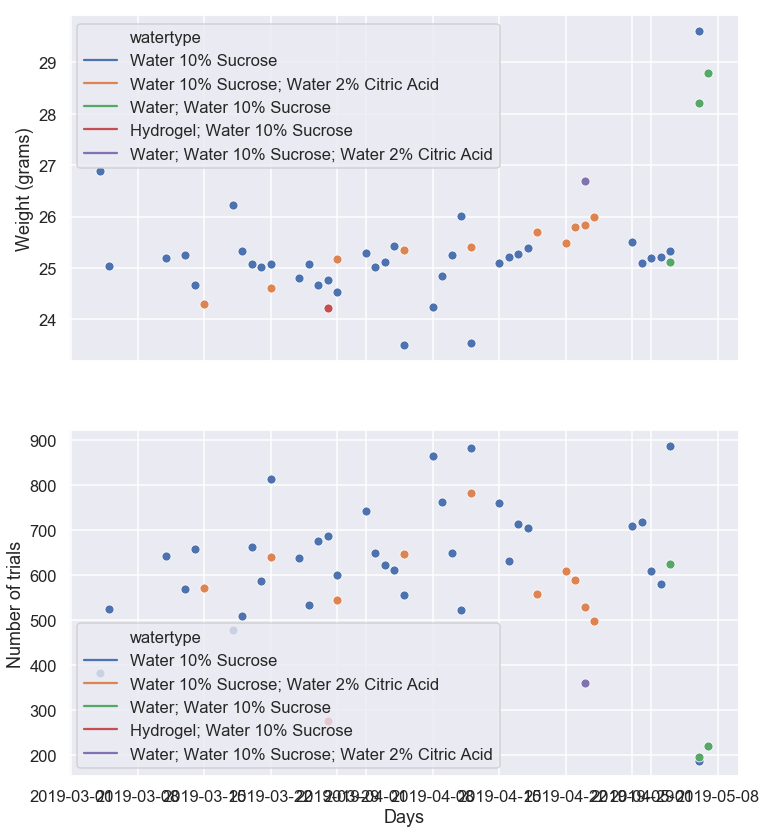

In [29]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(2,1, sharex=True, figsize=(12, 14))
sns.lineplot(x="session_date", y="avg_weight", hue="watertype", marker='o', linewidth=0, ci=None, data=df, ax=ax[0])
ax[0].set(ylabel="Weight (grams)", xlabel="Days")
sns.lineplot(x="session_date", y="n_trials", hue="watertype", marker='o',  linewidth=0, ci=None, data=df, ax=ax[1])
ax[1].set(ylabel="Number of trials", xlabel="Days")

Now that we have our data, let's visualize it!

The plot above shows an example of using seaborn (https://seaborn.pydata.org/index.html), see the documentation for many other types of plots you can make. 

Try to make this plot a bit nicer, by doing the following:
1. move the legend to the right of the plot, or make it smaller so it doesn't obscure the datapoints. you can also rotate the 'tickmarks' (dates) on the x-axis to make them more readable.
2. play with the arguments to 'lineplot' - see e.g. what happens when linewidth=1, or ci=95
3. instead of marking each day by its water condition _that day_, change the dataframe to label it with the condition of _that week_ (so that e.g. a week with only 10% sucrose water, but _preceded_ by a 2% CA weekend is different from a week with 10% sucrose water, but _preceded by a regular water weekend). this should then indicate the color
4. check in Alyx that all mice on a given day have the same 'condition'. Also make sure there are data logged for each day, including the weekend.
4. repeat the plot for individual mice (hint: seaborn's FacetGrid)

Of these, 3 and 4 are the most important: the rest is 

Once this looks good, try to create a new plot that ignores the date, and plots all datapoints (weight and nr of trials) from one condition (weekend + week water regime) in one overview - as on the SfN poster. You can use e.g. seaborn's catplot to make it look nice.